In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, RocCurveDisplay

from statistics import stdev
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")


##1.문제정의

* 환자데이터를 활용하여 이 환자가 당뇨병인지 아닌지 분류하여 판단한다.

## 2.데이터 EDA & 전처리

##의료환자데이터



* gender	= 성별
* age	    = 나이
* hypertension	= 고혈압 여부
* heart_disease = 심장병 여부
* smoking_history	 = 흡연여부
* bmi	=체지방지수
* HbA1c_level	= 혈액내 포도당지수
* blood_glucose_level	= 혈압수치
* diabetes = 당뇨병 여부


In [5]:
df = pd.read_csv("C:\\Users\\BIG3-04\\Downloads\\archive (14)\\diabetes_prediction_dataset.csv")

In [6]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [8]:
for col in df.select_dtypes('object'):
  target = df[col]
  print("-------------------")
  print(target.value_counts())

-------------------
gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64
-------------------
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


In [9]:
df['gender'] = df['gender'].replace({'Other': 'Female'}, limit=11)
df['gender'] = df['gender'].replace({'Other': 'Male'}, limit=7)

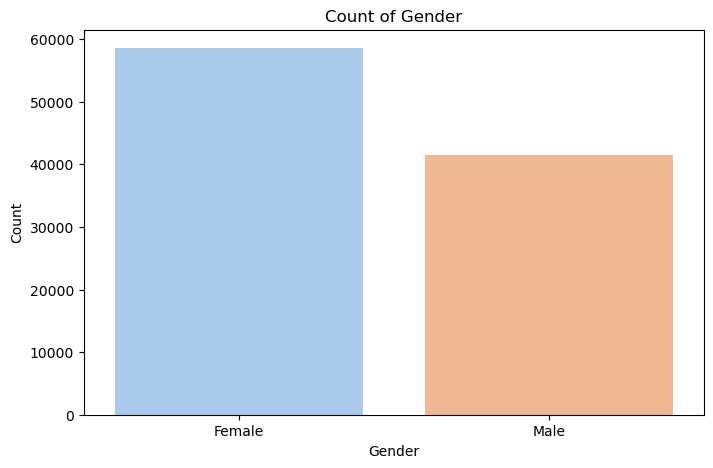

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', data=df, palette='pastel')
plt.title('Count of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [11]:
#고혈압과 혈당으로 결측치 판단
df['smoking_history'] = df['smoking_history'].replace({'No Info': None})
smoking_table = df.groupby(['blood_glucose_level', 'hypertension'])['smoking_history'].agg(lambda x: x.mode().iat[0] if x.notna().any() else None).reset_index()
smoking_table

,blood_glucose_level,hypertension,smoking_history
0,80,0,never
1,80,1,never
2,85,0,never
3,85,1,never
4,90,0,never
5,90,1,never
6,100,0,never
7,100,1,never
8,126,0,never
9,126,1,never


In [12]:
df['smoking_history'] = df['smoking_history'].fillna('never')

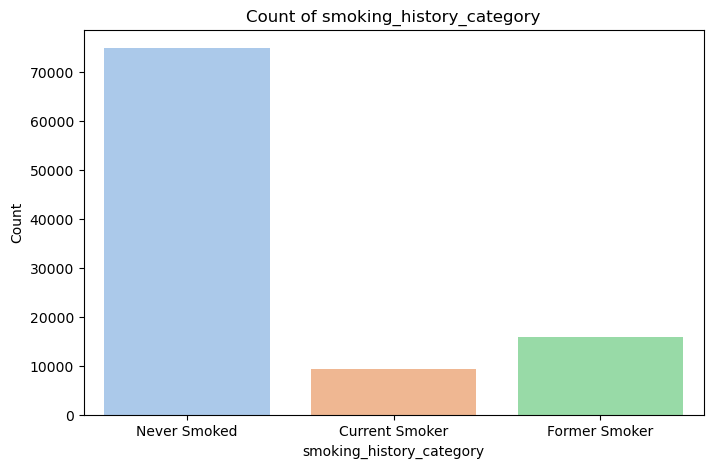

In [13]:
def categorize_smoking_history(x):
    if x in ['former','not current']:
        return 'Former Smoker'
    elif x in ['never','ever']:
        return 'Never Smoked'
    return 'Current Smoker'
df['smoking_history_category'] = df['smoking_history'].apply(categorize_smoking_history)
df['smoking_history_category'].value_counts()
plt.figure(figsize=(8, 5))
sns.countplot(x='smoking_history_category', data=df, palette='pastel')
plt.title('Count of smoking_history_category')
plt.xlabel('smoking_history_category')
plt.ylabel('Count')
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
df['smoking_history_encoded'] = label_encoder.fit_transform(df['smoking_history_category'])
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])
columns_drop = ['gender', 'smoking_history','smoking_history_category']
df.drop(columns=columns_drop, inplace=True)

## 3. 데이터 분석 기법 선정 이유

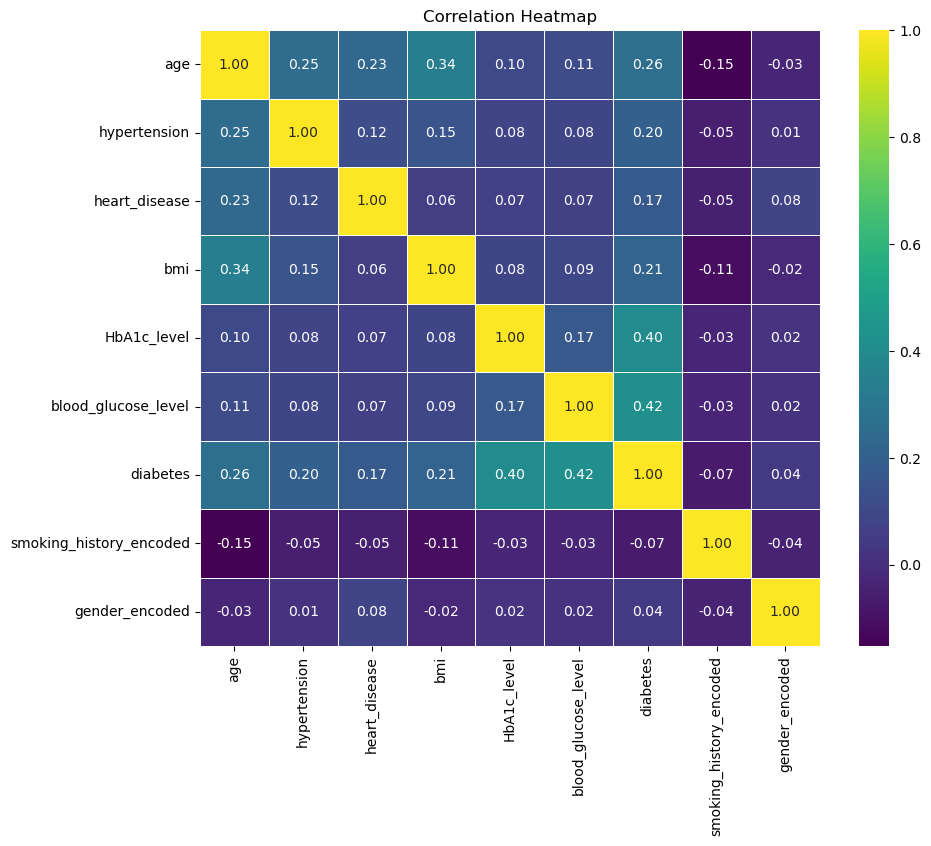

In [15]:
df.corr()
correlation_matrix = df.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [17]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 데이터 준비
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 랜덤 오버샘플링
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

# 랜덤 포레스트 모델 생성 및 학습
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_resampled, y_resampled)

# 테스트 데이터로 예측
y_pred = rf_clf.predict(X_test_scaled)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# 분류 보고서 출력
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9641

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.83      0.72      0.77      1700

    accuracy                           0.96     20000
   macro avg       0.90      0.85      0.88     20000
weighted avg       0.96      0.96      0.96     20000

